# 분류 모델

## XGBoost

* 분류에 있어 일반적으로 다른 머신러닝 알고리즘보다 뛰어난 예측 성능을 보인다.
* GBM에 기반하고 있지만 느린 수행시간, 과적합 규제 기능 미포함 등 GBM알고리즘이 지닌 단점들을 극복
* 교차검증을 자체 내장, 최적화가 이뤄지면 반복을 중간에 멈추는 조기 중단 기능 존재
* 두가지의 종류가 존재한다
    - Python wrapper
        * 출시 초기형
        * scikit-learn과 호환 x
        * 통용되는 scikit-learn의 머신러닝 프로세스를 활용할 수 없음
    - Scikit-learn wrapper
        * Python 기반 머신러닝 이용자들이 일반적으로 사용하는 scikit-learn과 호환

### XGBoost의 주요장점
|항목|설명|
|----|----|
|뛰어난 예측 성능|분류와 회귀 영역에서 뛰어난 예측 성능 발휘|
|GBM대비 빠른 수행시간|XGBoost은 병렬 수행 및 다양한 기능으로 GBM에 비해 빠른 수핸 성능 보장|
|과적합 규제(Regularization)|XGBoost는 자체에 과적합 규제 기능으로 과적합에 좀 더 강한 내구성 지님|
|Tree pruning(나무 가지치기)|Tree pruning으로 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 줄이는 강점 지님|
|자체 내장된 교차 검증|XGBoost는 반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차 검증을 수행해 최적화된 반복 수행 횟수 가짐|
|결손값 자체 처리|XGBoost는 결손값을 자체 처리할 수 있는 기능을 지님|

### Python Wrapper XGBoost

In [1]:
# 파이썬 래퍼 XGBoost 적용 – 위스콘신 유방암 예측
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [2]:
# 유방암 악성종양 양성여부를 확인할 수 있다
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [3]:
# 마지막열을 제외한 컬럼들을 X_feature에 저장
# cancer_df의 맨 마지막 컬럼이 레이블(target)이므로 제외
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 학습/테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

# 학습데이터를 다시 학습/검증 세트로 분리(이 때, 안정성을 위해 되도록 random_state는 동일하게 사용)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)
print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [4]:
# 학습, 검증, 테스트용 DMatrix를 생성(XGBsoot에서 사용 가능한 형태로 변환)
# 학습데이터
dtr = xgb.DMatrix(data = X_tr, label = y_tr)

# 검증데이터
dval = xgb.DMatrix(data = X_val, label = y_val)

# 테스트데이터
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [5]:
params = { 'max_depth':3,  # 트리의 최대 깊이
          'eta': 0.05,   # 학습률 : 학습률이 작으면 학습 속도가 느리지만 정확한 예측 성능을 보임.(일반적으로 0.01~0.2 사이)
          'objective':'binary:logistic',  # 최소화할 손실 함수를 결정
          'eval_metric':'logloss'  # 성능평가 지표
         }
# 모델 학습 수행 횟수
num_rounds = 400

In [6]:
# 학습데이터 셋은 'train', 평가데이터 셋은 'eval'로 정의
eval_list = [(dtr, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, early_stopping_rounds = 50, evals = eval_list)

# params: XGBoost 모델에서 사용할 하이퍼 파라미터들을 담은 딕셔너리(max_depth, eta, objective, eval_metric 등이 포함)
# dtrain: 학습에 사용할 DMatrix 형식으로 변환된 학습 데이터
# num_boost_round: 모델을 학습할 횟수
# early_stopping_rounds: 일정한 횟수 동안 검증 데이터의 성능이 개선되지 않으면 학습을 조기 종료하는 조건
# evals: 검증 데이터를 사용하여 모델의 예측 성능을 평가하는 인자(여러 개의 검증 데이터를 사용할 수 있으며, 딕셔너리 형태로 지정)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086


In [7]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
# pred_probs에서 첫 10개의 예측 확률 값을 소수점 세 자리까지 반올림
print(np.round(pred_probs[:10], 3))

# 예측 확률 값이 0.5보다 큰 경우 1로 분류, 그렇지 않은 경우 0으로 분류
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# pred : 예측값, pred_proba : 예측확률값
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [9]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

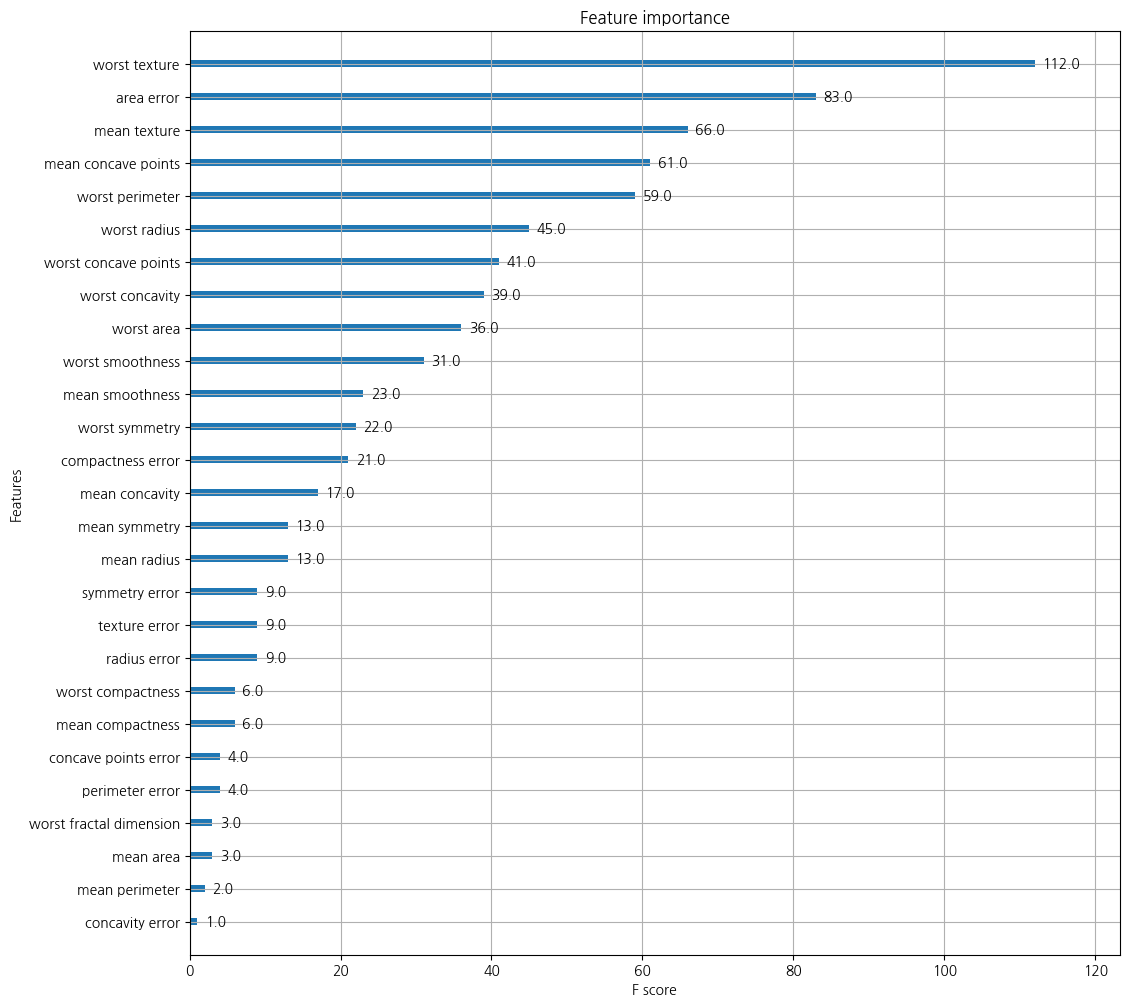

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
# fig : 전체그래프, ax : 축, plt.subplots(): 새로운 figure와 axes 객체를 생성
fig, ax = plt.subplots(figsize = (12, 12))
plot_importance(xgb_model, ax = ax)

### fig ,ax의 정의
* fig(figure): 데이터가 담기는 프레임. 크기, 모양을 변형할 수 있지만 실제로 프레임 위에 글씨를 쓸 수 없다. 여러 그래프가 담길 수 있는 액자 같은 역할
* ax(axes): 실제 데이터가 그려지는 캔버스, 모든 plot은 이 axes위에서 이루어져야 한다
* 실제 완성한 하나의 figure(하나 혹은 여러 개의 플롯을 포함한 개체)를 저장할 때는 fig 변수를 활용
* savefig 함수를 활용하여 png, jpg, svg 세 가지 형태 중 하나로 저장 가능하며, 저장 화질역시 설정가능하다.

### Scikit-learn Wrapper XGBoost

In [11]:
# XGBClassifier 임포트
from xgboost import XGBClassifier
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [12]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [13]:
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [14]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


* 만일 early_stopping_rounds를 10으로 하면, 아직 성능이 향상될 여지가 있음에도 불구하고 10번 반복하는 동안 성능지표가 향상되지 않으면 반복이 멈춰 버려서 충분한 학습이 되지 않아 성능이 나빠질 수 있다.

In [15]:
# early_stopping_rounds를 10으로 설정하고 재 학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = evals, verbose = True)
# early_stopping_rounds: 조기 중단을 적용하는 라운드 수(지정된 라운드 수동안 성능이 향상되지 않으면 학습이 조기 중단)
# eval_metric: 모델의 평가 지표(Evaluation Metric): 로그 손실함수 사용
# eval_set: 학습 데이터셋과 검증 데이터셋에 대한 튜플(모델 학습 과정에서 검증 데이터셋에 대한 평가 지표 출력)
# verbose: 학습 과정에서 로그 메시지를 출력할 지 여부를 결정하는 파라미터(True로 지정하면 학습 과정에서 로그 메시지가 출력)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [16]:
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9947


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

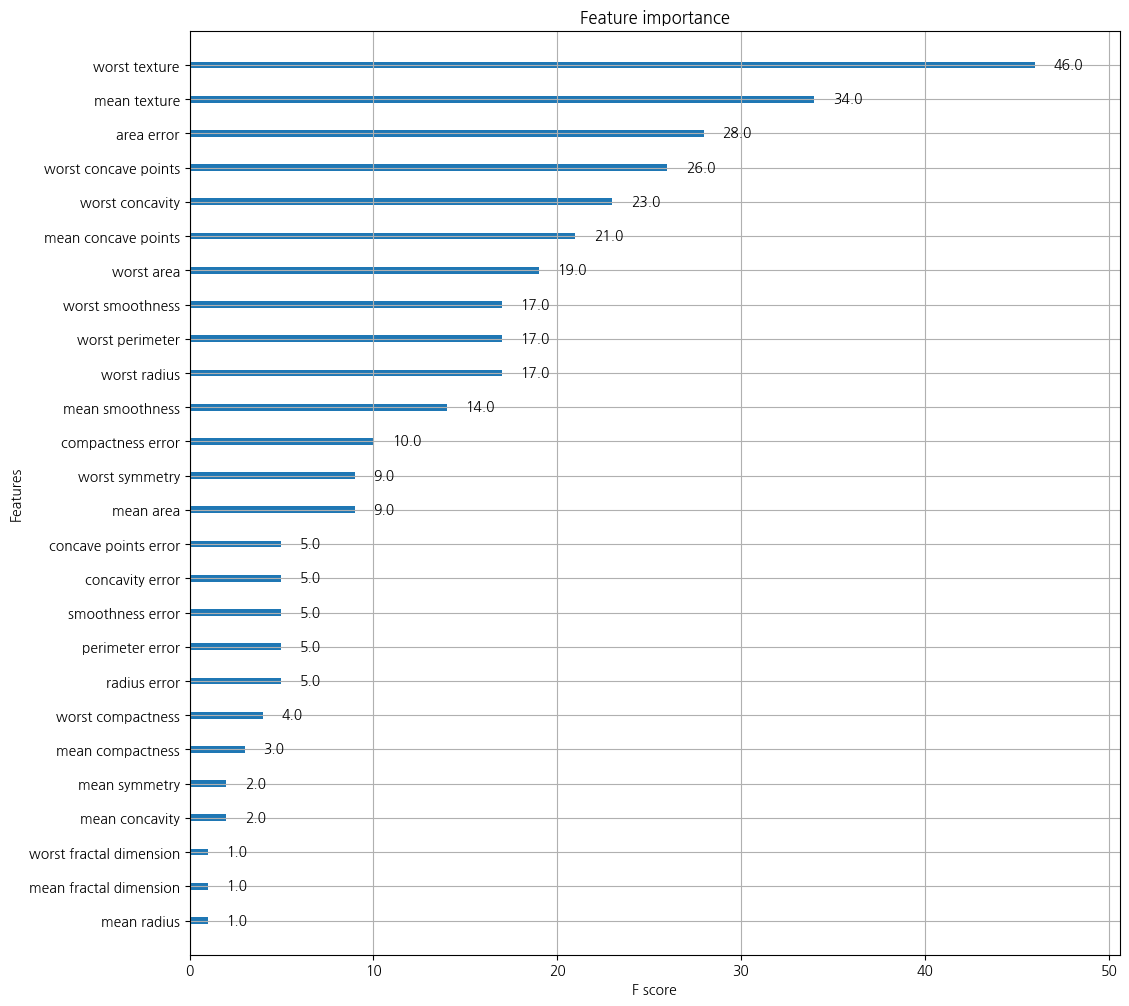

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

## LightGMB

* XGBoost는 GBM보다 빠른 뛰어난 부스팅 알고리즘이지만 여전히 학습 시간이 오래 걸린다.
* 이러한 단점을 보완하기 위해 등장한 것이 LightGMB이다.
* light: 예측성능은 큰 차이가 없으나 XGBoost보다 학습 시간이 훨씬 빠르며 메모리 사용량도 상대적으로 적음
* 다른 GBM 계열 알고리즘들이 사용하는 균형 트리 분할(Level Wise)이 아닌 리프 중심 트리 분할(Leaf Wise)방식 사용

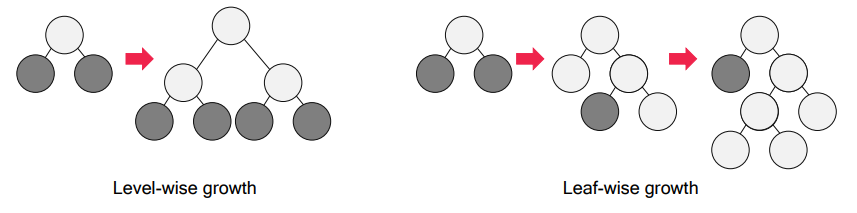

### 균형 트리 분할(Level Wise)
* depth별 leaf수를 맞추면서 최대한 균형적인 트리를 유지하며 분할
* 과적합에 강함

### 리프 중심 트리 분할(Leaf Wise)
* 트리 균형을 맞추지 않고 정보의 최대 손실감소(손실 함수 최소화)가 가능한 리프 노드에 집중하여 지속적으로 분할
* 예측에 대한 오류 손실 최소화
* 클래스 불균형 데이터 내 소수 클래스 예측에 강점
* 적은 데이터 세트 사용 시 과적합에 취약: manual 기준 적은 데이터의 기준은 10000건 이하
* XGBoost와 마찬가지로 Python Wrapper, Scikit-learn Wrapper 두 종류가 존재함

In [18]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
cancer_df['target']= dataset.target
cancer_df.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


In [19]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [20]:
# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400, learning_rate = 0.05)

# XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]

# 50회만큼 성능이 향상되지 않으면 조기 중단
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = 'logloss', eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, -1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [22]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

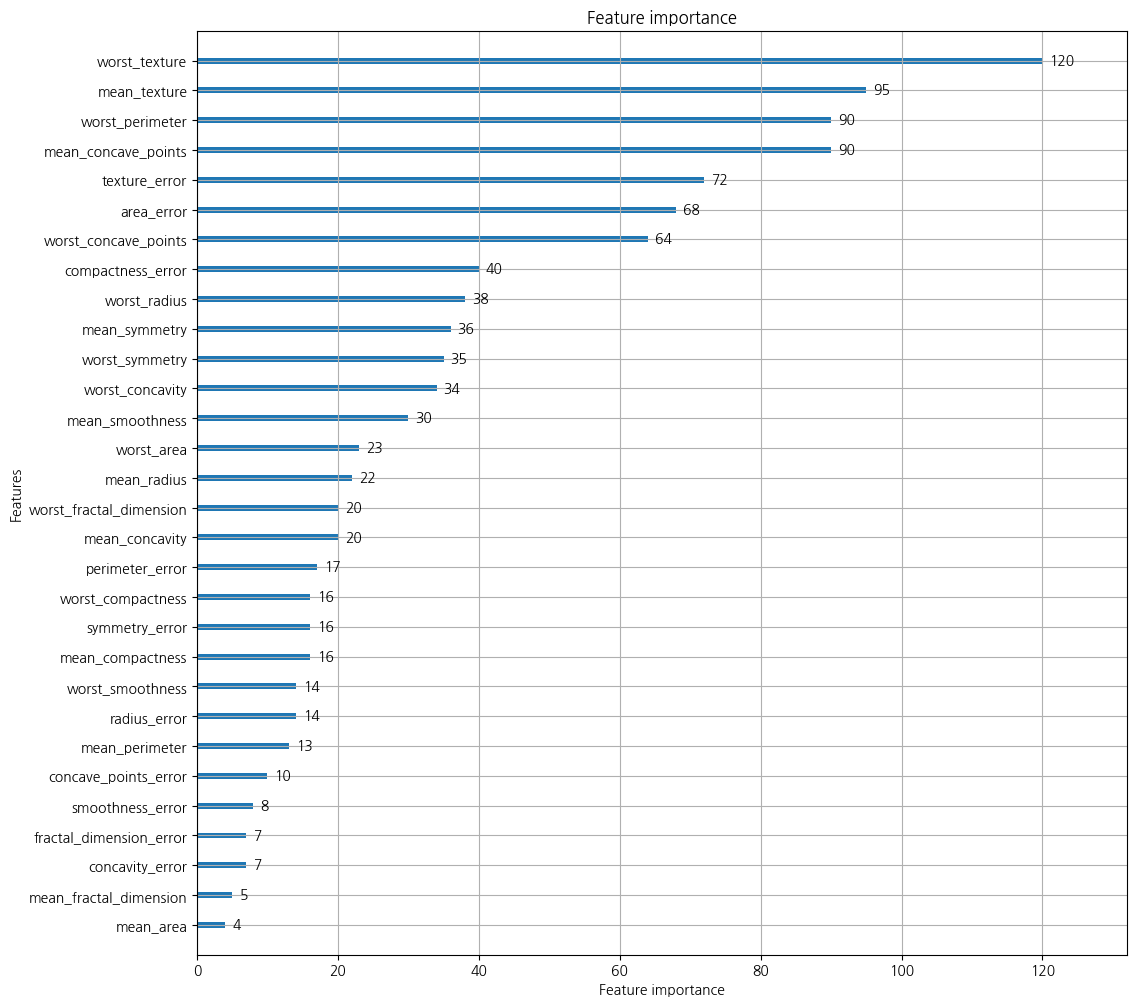

In [23]:
from lightgbm import plot_importance  # plot_importance( )를 이용하여 feature 중요도 시각화
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 12))
plot_importance(lgbm_wrapper, ax=ax)

## 회귀(Regression) 

* 독립변수와 종속변수 간의 함수적인 관련성을 규명하기 위하여 어떤 수학적 모형을 가정하고, 이 모형을 측정된 자료로부터 통계적으로 추정하는 분석방법
* 데이터의 값이 결국 평균과 같은 일정한 값으로 돌아가려는 경향을 이용한 통계학 기법
* (ex) 내 키가 아무리 크거나 | 아무리 작더라도 부모님, 조부모님, 조상님, ... 키의 평균과의 유사한 경향성을 보임
→ 경향성을 분석해 내 키(종속변수)와 부모님, 조부모님, ... 키(독립변수)와의 관계를 가장 잘 설명하는 함수식(회귀선, 회귀식)을 찾아내면 내 키가 얼마나 더 클지, 내 자식의 키는 얼마나 될지 추론 가능
* 머신러닝에 적용 시 : 종속변수(Y, target)와 여러개의 독립변수(X, features)간의 상관관계를 가장 잘 설명하는 회귀식을 도출하기 위해서 최적의 회귀 계수를 학습을 통해 찾아내고 모델링
* 분류 알고리즘과 구분되는 가장 중요한 차이: 분류 기법은 예측값이 이산형이지만, 회귀 기법은 예측값이 연속형

* **독립변수**: 원인에 해당, 설명변수 또는 예측변수, 특성변수(머신러닝)라고도 불림
* **종속변수**: 결과에 해당, 반응변수 또는 목표변수, 타겟변수(머신러닝)라고도 불림

### 회귀의 종류

|독립변수의 개수|종속변수의 개수|회귀 계수의 선형/비선형|
|----|----|----|
|1개: 단순(단일) 회귀|1개: 단변량(일변량) 회귀|선형 회귀|
|여러 개: 다중회귀|여러 개: 다변량 회귀|비선형 회귀|


### 회귀식
- 단순 단변량 선형회귀를 '단순 선형 회귀'로 부르며 회귀식은 다음과 같음<br> : 
$Y=WX+b$
- 다중 단변량 선형회귀를 '다중 선형 회귀'로 부르며 회귀식은 다음과 같음<br> : $Y=W_1X_1+W_2X_2+W_3X_3+...+W_nX_n+b$

- 머신러닝을 통해 찾아내고자 하는 회귀 계수는 상기 회귀식에서의 $W$와 $b$
  - $W$ : $X$에 대한 가중치 (weight): 수업 내용에서는 'b'로 표현
  - $b$ : $X$가 모두 0일때의 절편, 예측값과 실제값 사이를 조정하기 위한 편향 (bias): 수업 내용에서는 'a'로 표현

### 통계적 회귀식

* 단순선형회귀모형

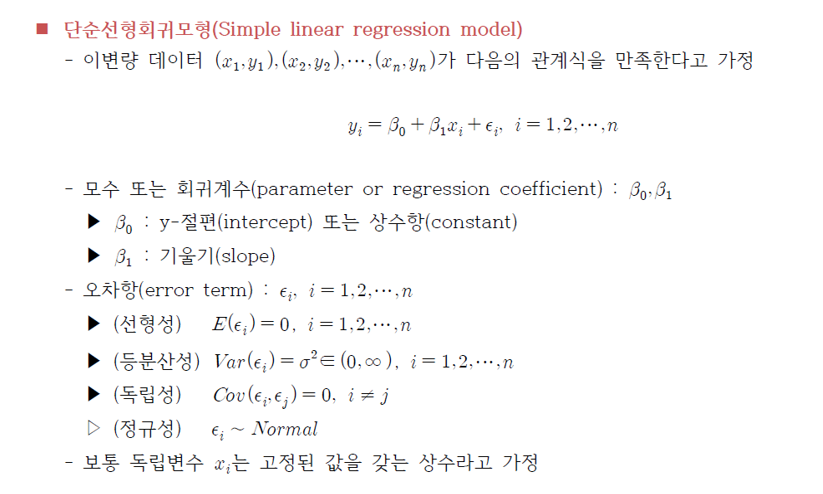

* y절편(상수항): x가 0일때 y의 기댓값이 얼마인지 나타냄
* 기울기: x가 한 단윕 증가할 때, y가 평균적으로 기울기만큼 변화한다는 의미

* 다중회귀모형

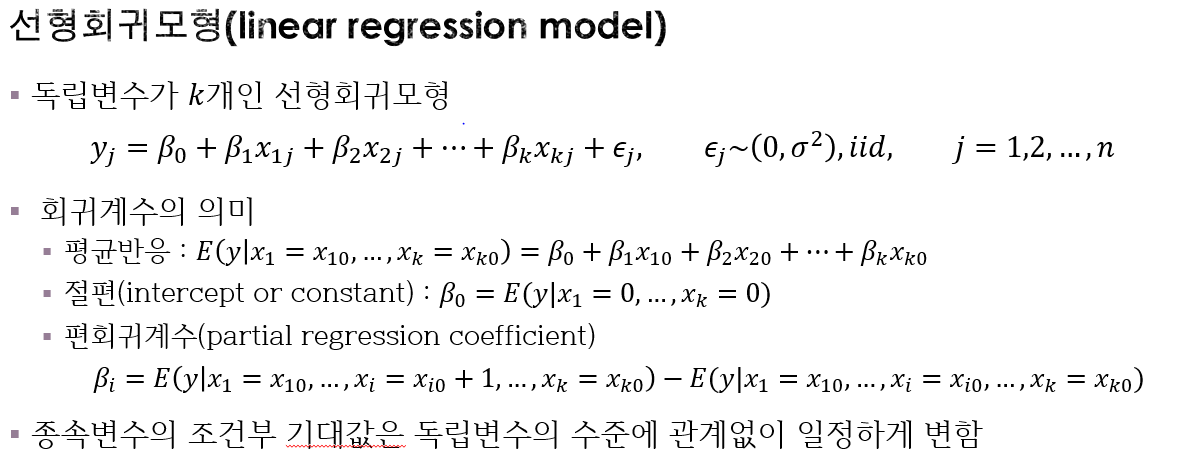

### 단순 선형 회귀를 통한 회귀 이해

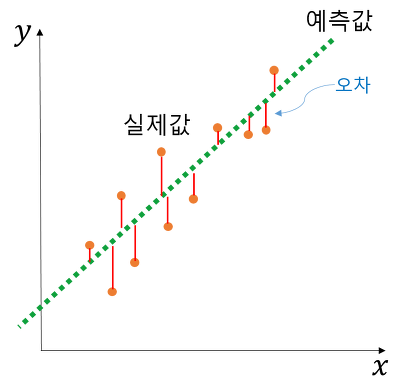

* 회귀선은 회귀식을 통해 산출된 값(기대값)을 바탕으로 독립변수와 종속변수 간의 관계를 설명하는 선이며, 실제 종속변수의 관측치(실제값)와는 차이가 존재한다.
* 관계를 가장 잘 설명하는 회귀선을 도출하기 위해선 '실제값'과 '기대값'의 차이, 즉 '오차 = 실제값 - 기대값' 이 최소화 되어야 한다.
* 오차는 '+'값과 '-'값 모두를 가지기 때문에 단순 오차의 총합은 0이되어 최소화를 수행할 수 없다.

* 따라서 오차의 합이 0이 되지 않도록 다음의 보정치를 사용한다.
  - **RSS(Residual Sum of Square)**: 오차의 제곱합<br>
  $RSS=\displaystyle\sum_{i=1}^{N}{(실제값-기대값)^2}$
  - **MSE(Mean Squared Error)**: 오차 제곱합의 평균<br>
  $MSE={1 \over N}\displaystyle\sum_{i=1}^{N}{(실제값-기대값)^2}$
  - **MAE(Mean Absolute Error)**: 오차 절대값의 평균<br>
  $MAE={1 \over N}\displaystyle\sum_{i=1}^{N}{|실제값-기대값|}$

* 관계를 가장 잘 설명하는 회귀식을 산출할 수 있도록 오차를 최소화 하는 대표적인 방법으로 '최소제곱법(Least Square Method, LSM)'과 경사하강법(Gradient Descent)' 두가지가 존재

|최소제곱법|경사하강법|
|----|----|
|해석적인 최적화 방식|반복적인 최적화 방식|
|방정식에서 해를 산출|반복적 대입을 통해 목표지점을 찾아감|
|빠르게 계산 가능|반복과정을 거치므로 속도가 느릴 수 있음|
|데이터의 크기가 커지거나 독립변수의 수가 많아질 경우, 방정식의 복잡도가 급증하여 메몰히 문제 발생|반복적 대임이므로 데이터가 크거나 독립변수의 수가 많더라고 문제없이 사용 가능|

### 최소제곱법

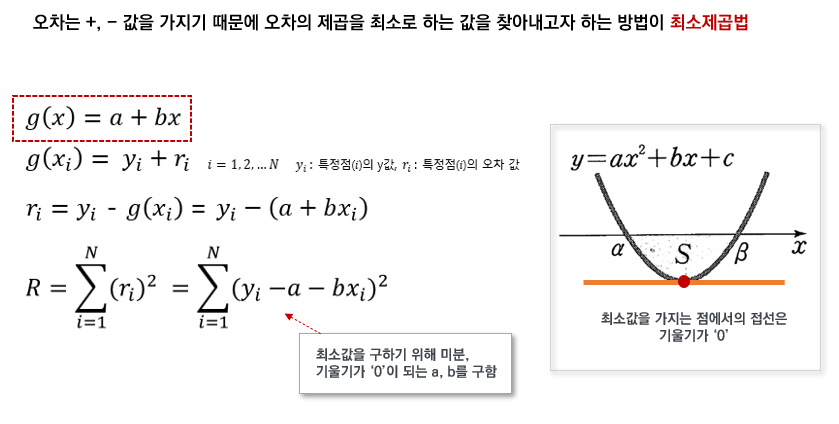

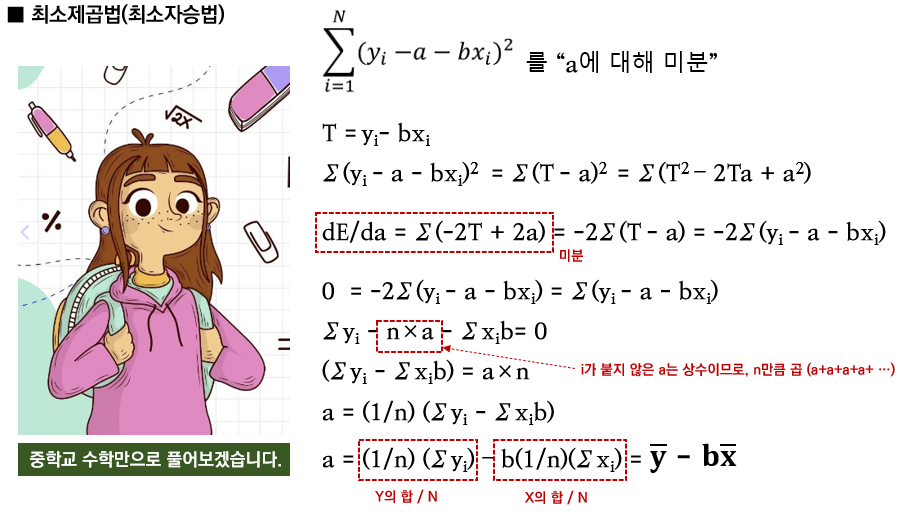

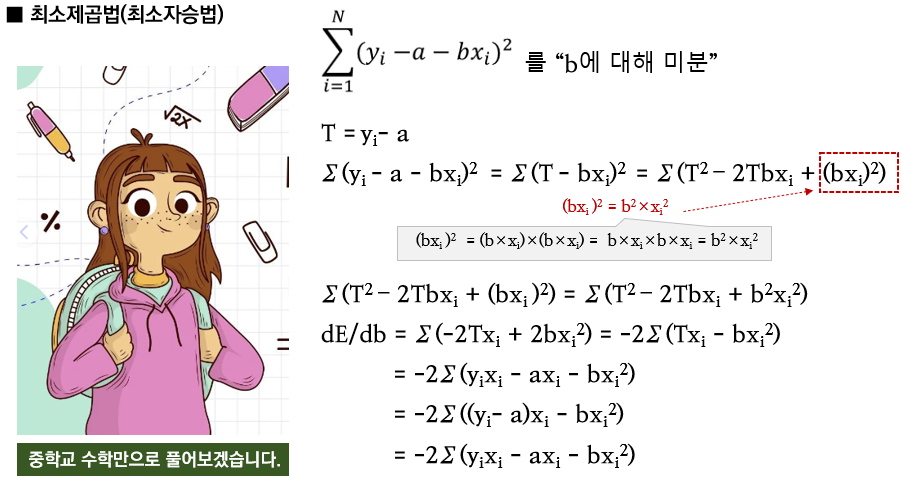

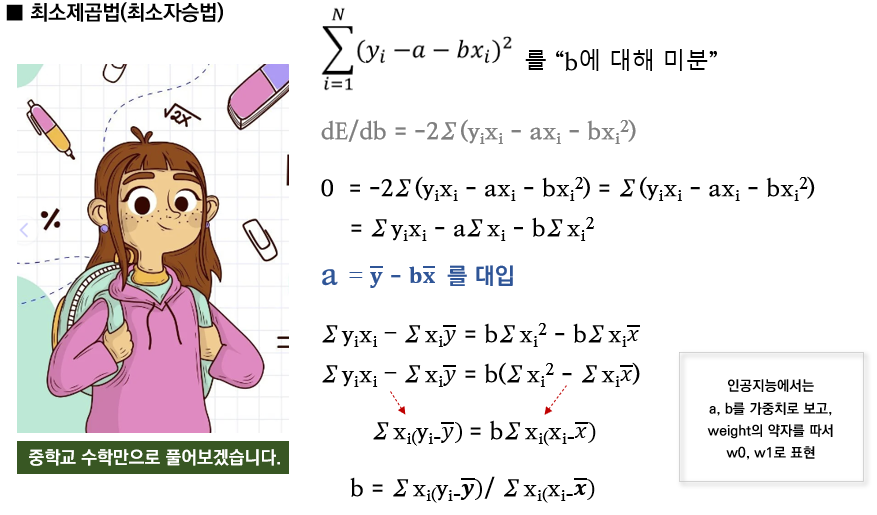

### 경사하강법

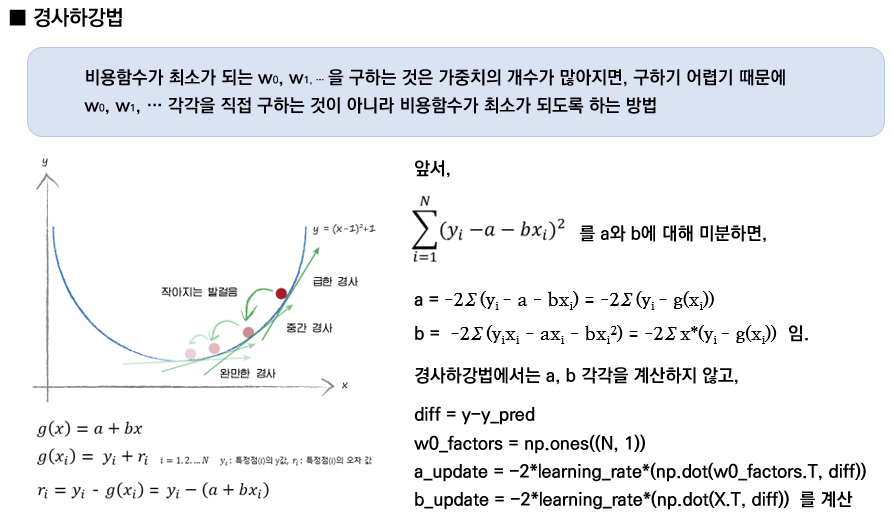

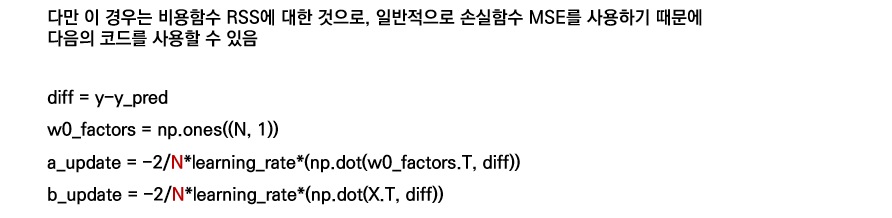

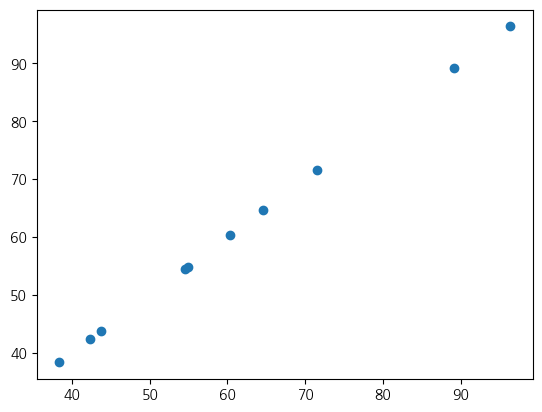

In [24]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(0)

X = 100 * np.random.rand(10,1)
y = X

plt.scatter(X, y)

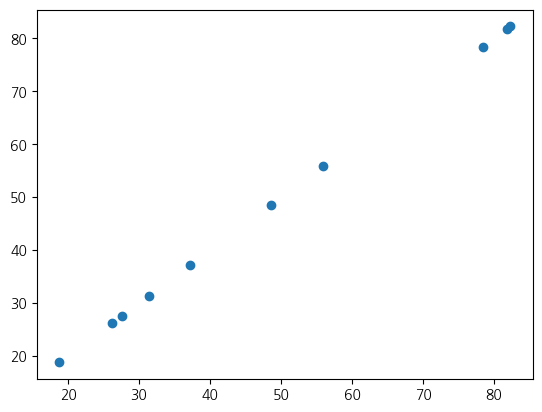

In [25]:
np.random.seed(156)

X = 100 * np.random.rand(10,1)
y = X

plt.scatter(X, y)

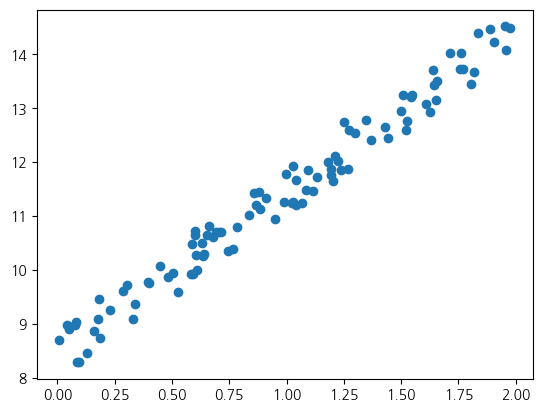

In [52]:
# 3X + 8을 근사하기 위한 100개 세트 구성
np.random.seed(10)

X = 2 * np.random.rand(100, 1)
y = 3 * X + 8 + np.random.rand(100, 1)

plt.scatter(X, y)

In [53]:
# X와 y의 형태 확인
X.shape, y.shape

((100, 1), (100, 1))

In [54]:
# 가중치 w0과 w1의 값을 최소화 할 수 있도록 업데이트 수행하는 함수 생성
# 기울기(w1), 절편(w0), 독립변수(X-100개행), 종속변수(y-100개행), 학습률(learning_rate) 
def get_weight_updates(w1, w0, X, y, learning_rate = 0.01):
    # 종속변수 y의 길이(100)를 N으로 저장
    N = len(y)
    
    # w1 배열 크기에 맞게 0으로 초기화(영행렬로 만들어줌)
    w1_update = np.zeros_like(w1)
    # w0 배열 크기에 맞게 0으로 초기화 
    w0_update = np.zeros_like(w0)

    # X와 w1의 전치행렬의 곱 + w0     (y = ax + b + r에서 a가 w1, b가 w0, r은 diff 라고 이해하면 된다)
    y_pred = np.dot(X, w1.T) + w0
    # 실제값과 예측값의 차이
    diff = y-y_pred  
    
    # w0의 업데이트를 위해 모든 원소가 1인 100행 생성 
    w0_factors = np.ones((N, 1))  

    # MSE를 이용해 업데이트값 조정
    w1_update = -(2 / N) * learning_rate * (np.dot(X.T, diff))
    # MSE를 이용해 업데이트값 조정
    w0_update = -(2 / N) * learning_rate * (np.dot(w0_factors.T, diff))   
    
    return w1_update, w0_update

In [55]:
# 입력 인자 iters로 주어진 횟수만킄 반복저으로 w1과 w0을 업데이트 적용하는 함수를 생성
def gradient_descent_steps(X, y, iters = 1000):
    # w0와 w1을 모두 0으로 초기화. 
    w0 = np.zeros((1, 1))
    w1 = np.zeros((1, 1))
    
    # 인자로 주어진 iters 만큼 반복적으로 get_weight_updates() 호출하여 w1, w0 업데이트 수행. 
    for ind in range(iters):
        w1_update, w0_update = get_weight_updates(w1, w0, X, y, learning_rate = 0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update
              
    return w1, w0

In [56]:
# 예측 오차 비용 계산을 수행하는 함수 생성 및 경사 하강법 수행
def get_cost(y, y_pred):
    N = len(y) 
    cost = np.sum(np.square(y - y_pred)) / N
    return cost

In [57]:
w1, w0 = gradient_descent_steps(X, y, iters = 1000)
print("w1:{0:.3f} w0:{1:.3f}".format(w1[0, 0], w0[0, 0]))
y_pred = w1[0, 0] * X + w0
print('Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y, y_pred)))

w1:3.127 w0:8.309
Gradient Descent Total Cost:0.0833


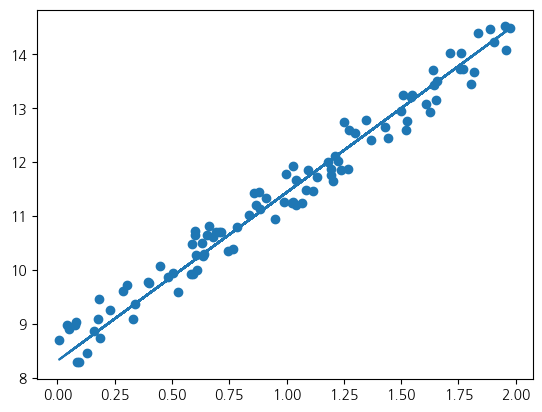

In [58]:
# 회귀분석 시각화
plt.scatter(X, y)
plt.plot(X,y_pred)